# Decision Tree

### Data Generation

<Figure size 640x480 with 0 Axes>

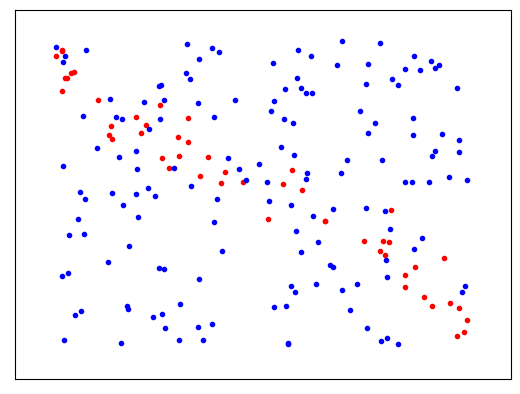

<Figure size 640x480 with 0 Axes>

In [1]:
import numpy as np
import sklearn.tree 
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay

from collections import namedtuple

class Data:
    RESOLUTION = 1000
    
    class DataSet:
        def __init__(self, N1, N2, seed=None):
            np.random.seed(seed)
            self.N = N1 + N2
            self.N1 = N1
            self.N2 = N2
            
            self.Y = np.zeros(shape=(self.N,))
            self.Y[N2:] = 1
            
            self.X = np.random.rand(N1 + N2, 2)
            self.X[:N2, 0] = np.cos(
                    self.X[:N2, 1] * 3.14 * 1 
                    + np.random.randn(N2)*0.2
                )/2 + 0.5
    
    def __init__(self):
        self.train = self.DataSet(150, 50, seed=1)
        self.test  = self.DataSet(1000, 1000, seed=0)
        self.xx, self.yy = np.meshgrid(
            np.linspace(-0.1, 1.1, self.RESOLUTION),
            np.linspace(-0.1, 1.1, self.RESOLUTION)
        )
        self.meshpoints =  np.c_[self.xx.ravel(), self.yy.ravel()]
        
    def show(self, ax):
        ax.set_xlim(-0.1, 1.1)
        ax.set_ylim(-0.1, 1.1)
        ax.set_xticks(())
        ax.set_yticks(())
        
        ax.plot(*self.train.X[:self.train.N2].T, '.', color='red')
        ax.plot(*self.train.X[self.train.N2:].T, '.', color='blue')
        
    def show_model(self, ax, model):
        Z = model.predict_proba(self.meshpoints)[:, 1]
        Z = Z.reshape(self.xx.shape)
        ax.contourf(self.xx, self.yy, Z, cmap='Spectral', alpha=.3)
        self.show(ax)
        
data = Data()

fig, ax = plt.subplots(1,1)
data.show(ax)
plt.figure()

## Max depth parameter

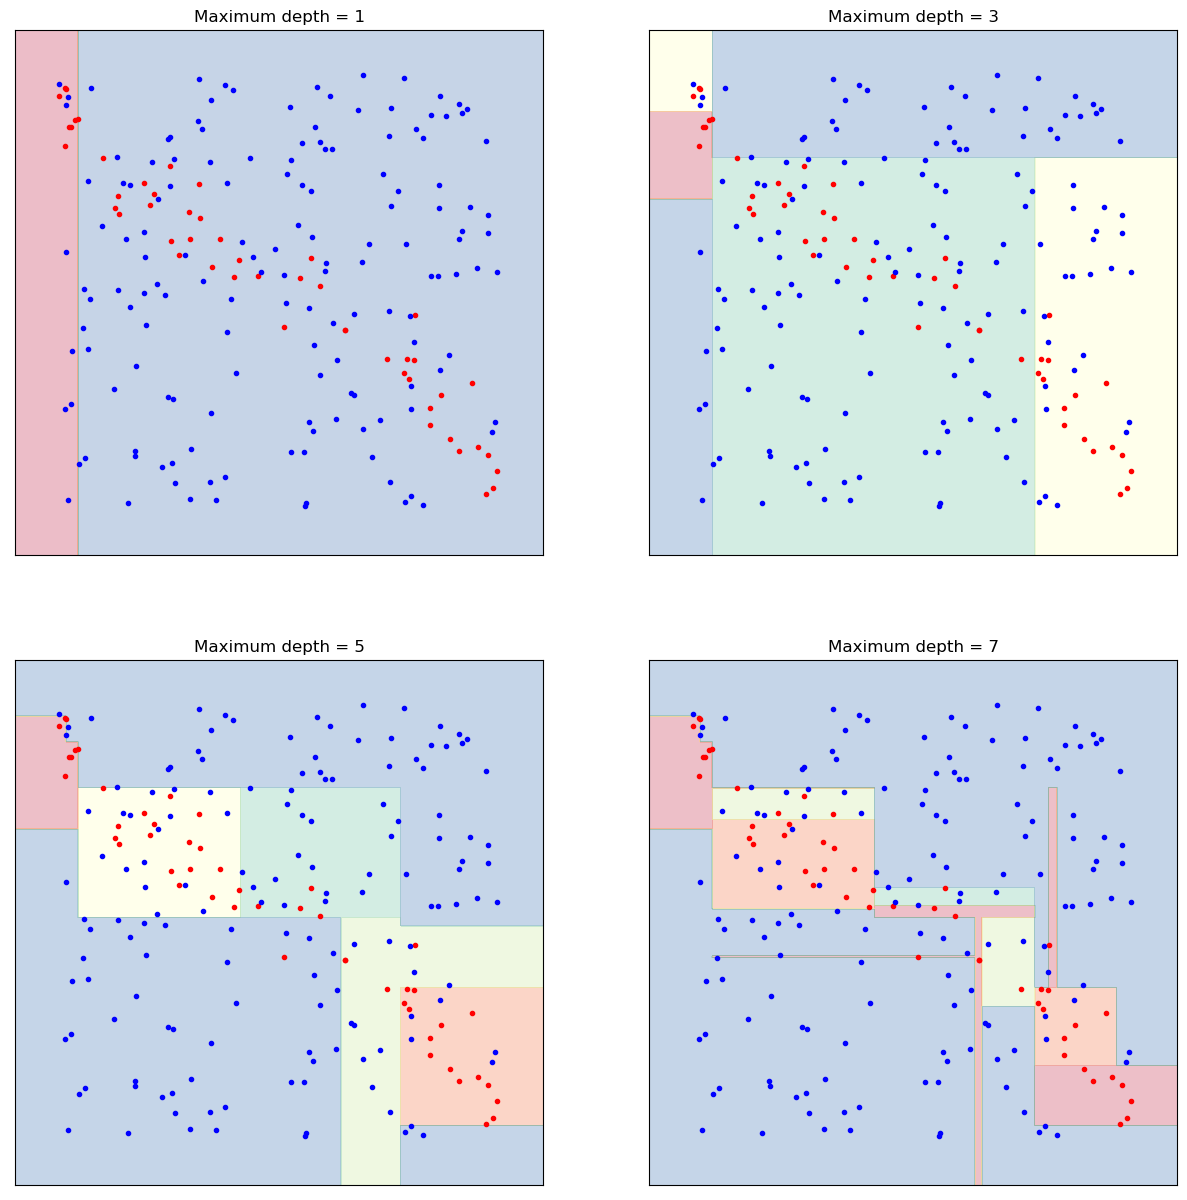

In [2]:
fig, axs = plt.subplots(2,2, figsize=(15,15))
axs = [*axs[0], *axs[1]]

for mxdp, ax in zip([1,3,5,7], axs):
    model = sklearn.tree.DecisionTreeClassifier(
        max_depth=mxdp,
    ).fit(data.train.X, data.train.Y)
    data.show_model(ax, model)
    ax.set_title(f'Maximum depth = {mxdp}')

## Minimum Samples Per Leaf Node

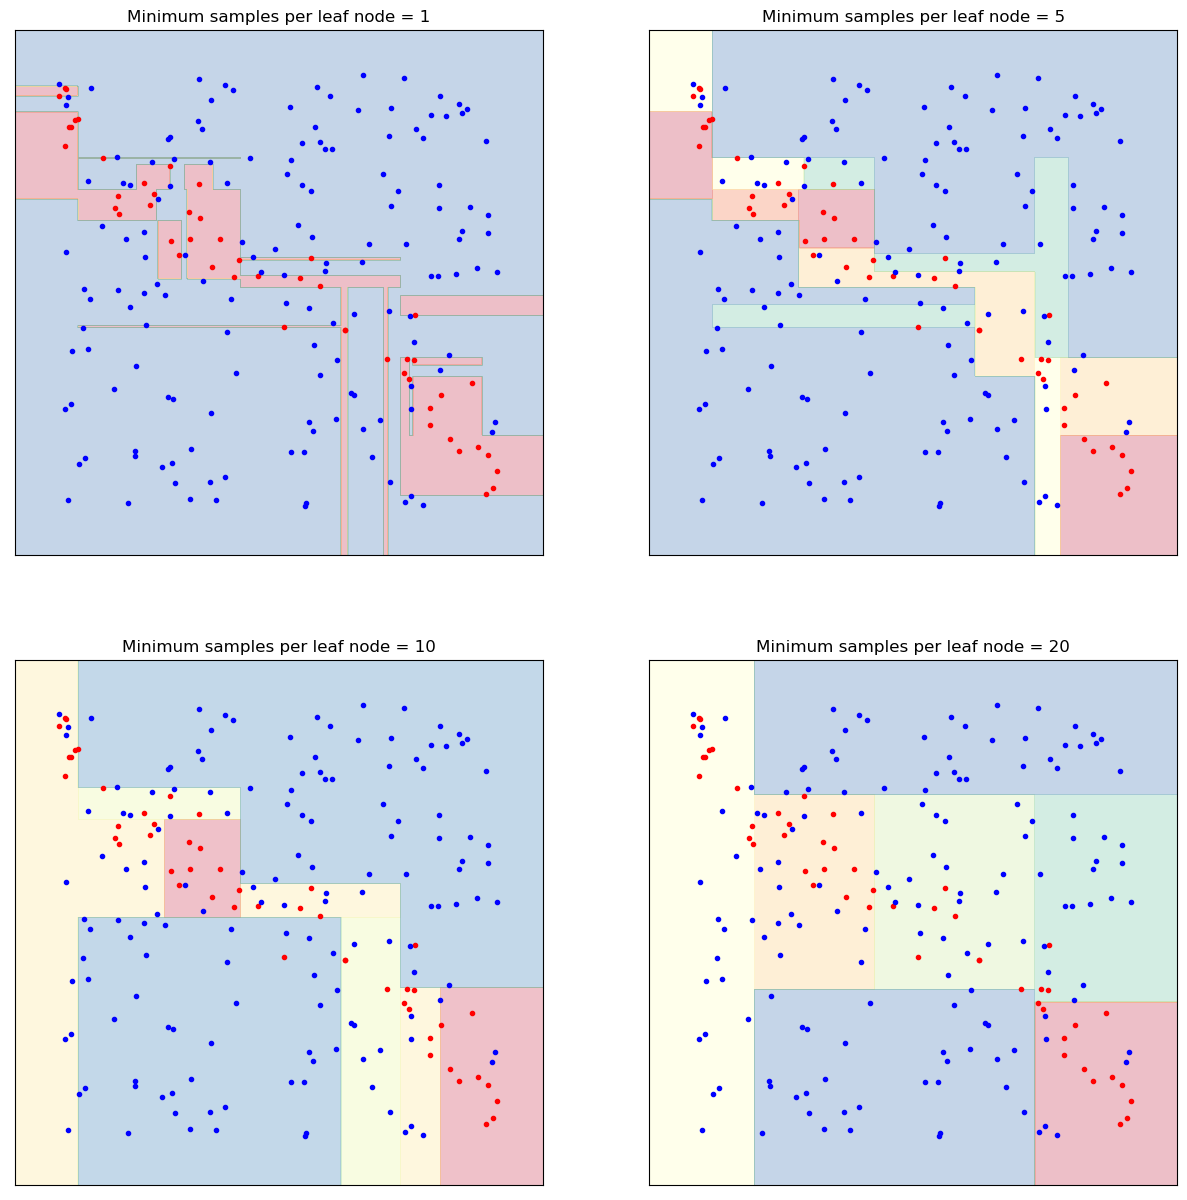

In [3]:
fig, axs = plt.subplots(2,2, figsize=(15,15))
axs = [*axs[0], *axs[1]]

for mxdp, ax in zip([1,5,10,20], axs):
    model = sklearn.tree.DecisionTreeClassifier(
        min_samples_leaf=mxdp
    ).fit(data.train.X, data.train.Y)
    data.show_model(ax, model)
    ax.set_title(f'Minimum samples per leaf node = {mxdp}')

## Criterion

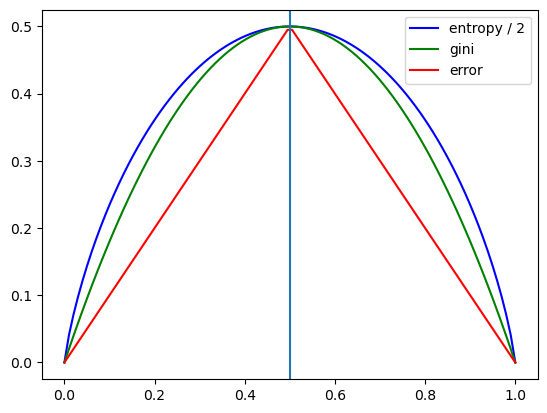

In [4]:
x = np.linspace(1e-7,1 - 1e-7, 100)
y_entropy = -x*np.log2(x) -(1-x)*np.log2(1-x)
y_gini = 1 - x**2 - (x-1)**2
y_error = 0.5 - np.abs(0.5 - x)


plt.plot(x, y_entropy / 2, color='blue', label='entropy / 2')
plt.plot(x, y_gini, color='green', label='gini')
plt.plot(x, y_error, color='red', label='error')
plt.axvline(0.5)
plt.legend()

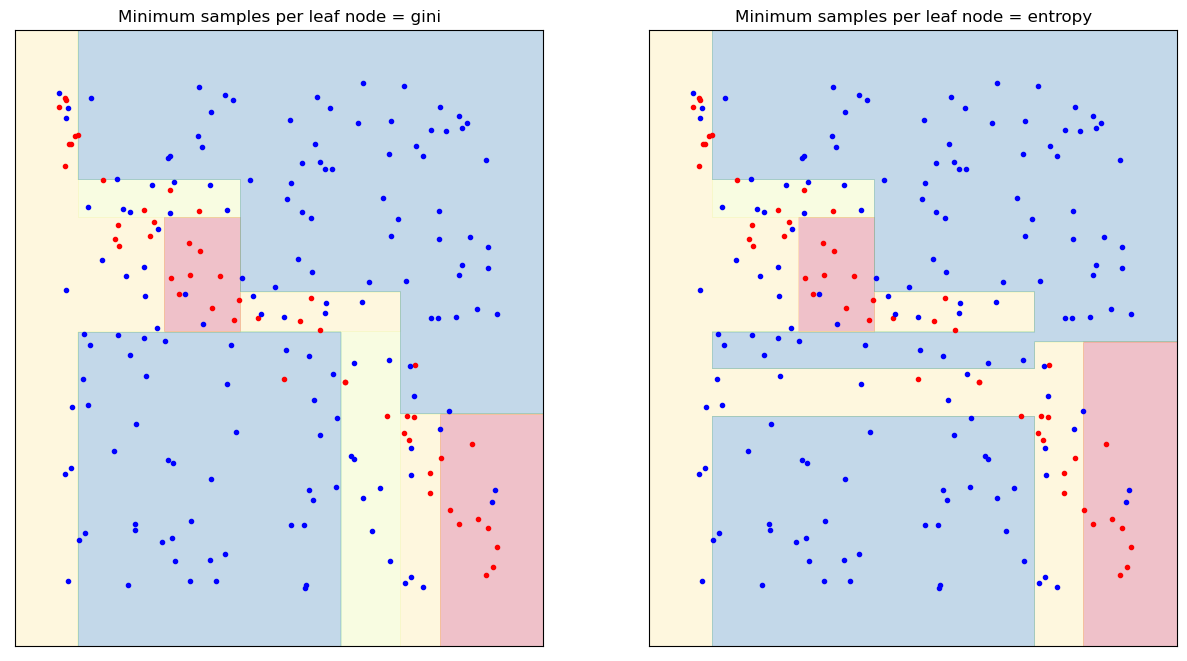

In [5]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

for mxdp, ax in zip(['gini', 'entropy'], axs):
    model = sklearn.tree.DecisionTreeClassifier(
        min_samples_leaf=10,
        criterion=mxdp
    ).fit(data.train.X, data.train.Y)
    
    data.show_model(ax, model)
    ax.set_title(f'Minimum samples per leaf node = {mxdp}')

# Random Forests

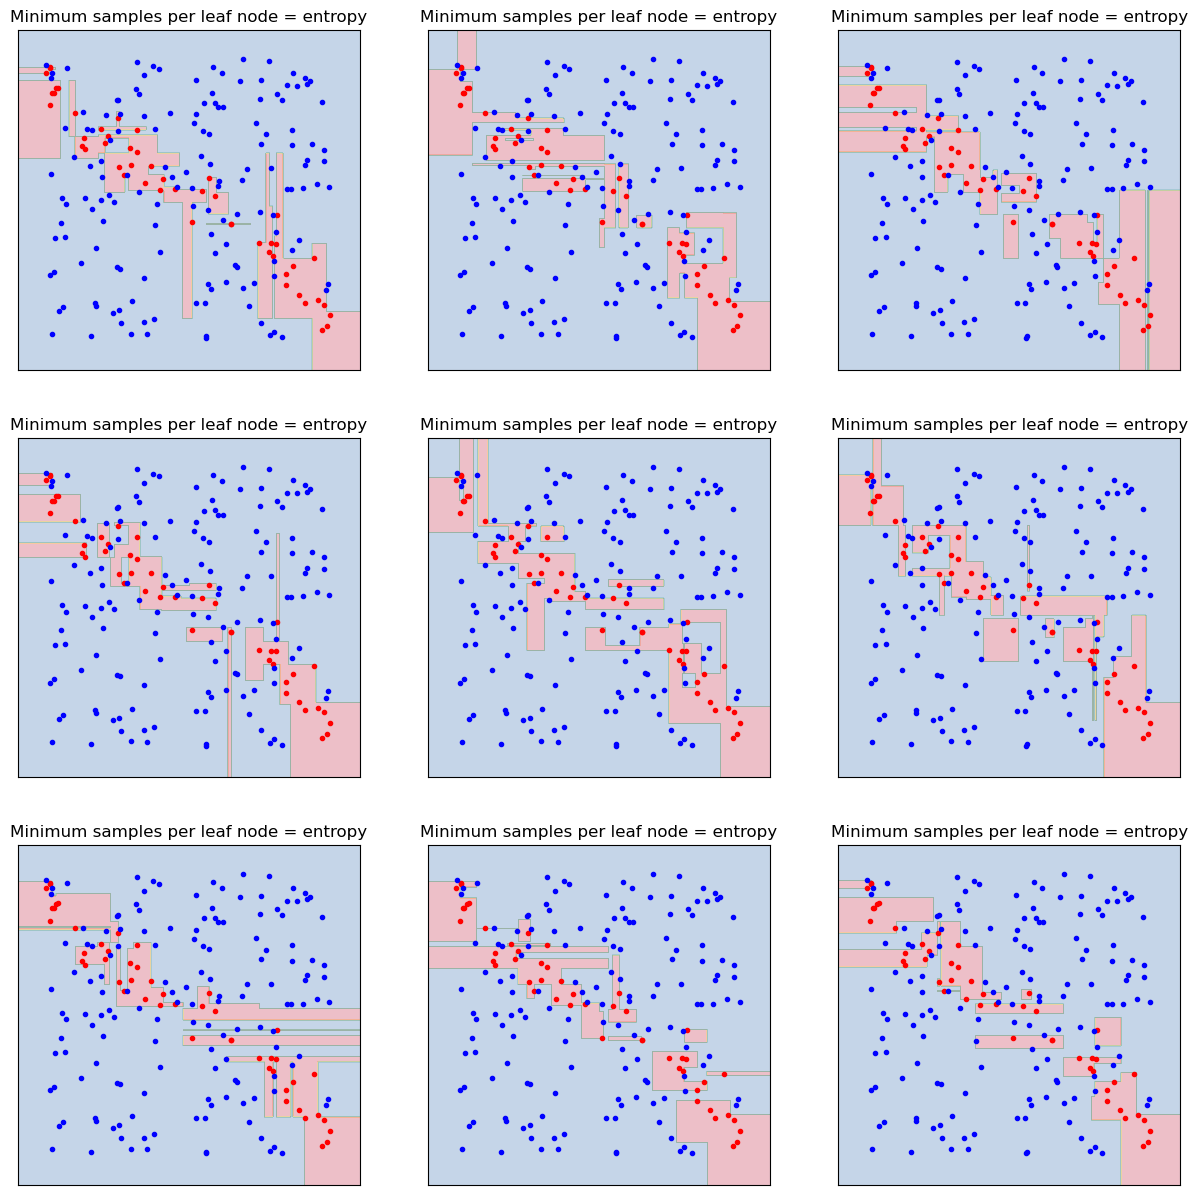

In [6]:
fig, axs = plt.subplots(3,3, figsize=(15,15))

axs = [*axs[0], *axs[1], *axs[2]]
models = []

for i, ax in enumerate(axs):
    model = sklearn.tree.DecisionTreeClassifier(
        splitter='random',
    ).fit(data.train.X, data.train.Y)
    models.append(model)
    
    data.show_model(ax, model)
    ax.set_title(f'Minimum samples per leaf node = {mxdp}')

Text(0.5, 1.0, 'Voting of 5 random tree models')

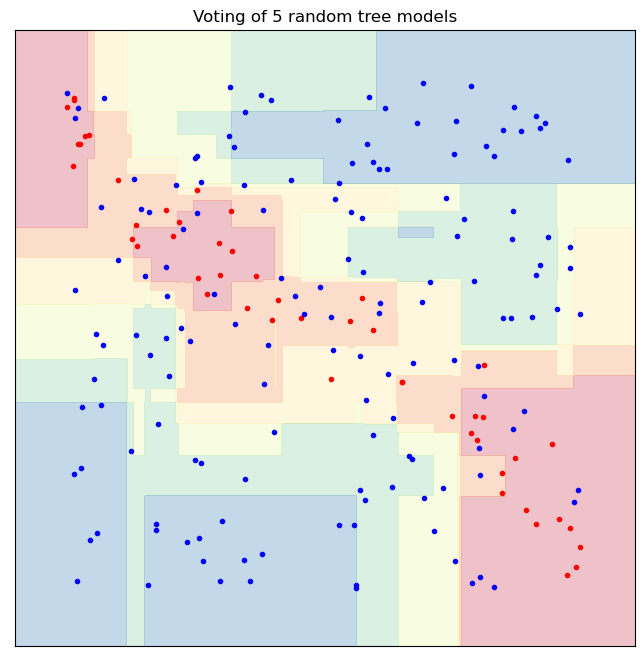

In [7]:
from sklearn.ensemble import VotingClassifier

base_model = sklearn.tree.DecisionTreeClassifier(
    splitter='random',
    class_weight='balanced',
    min_samples_leaf=5
)

model = VotingClassifier(
    [(f'submodel{i}', base_model) for i in range(5)], 
    voting='soft').fit(data.train.X, data.train.Y)

fig, ax = plt.subplots(1,1, figsize=(8,8))
data.show_model(ax, model)
ax.set_title('Voting of 5 random tree models')

Text(0.5, 1.0, 'Voting of 50 random tree models')

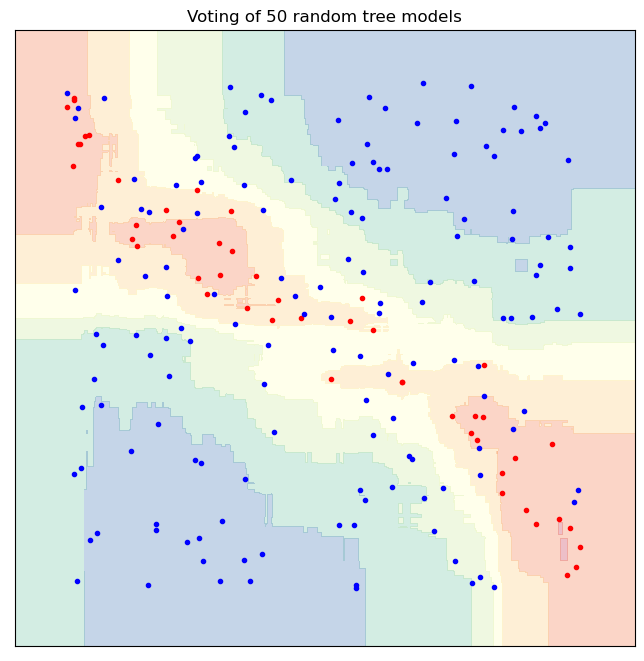

In [8]:
model = VotingClassifier(
    [(f'submodel{i}', base_model) for i in range(50)], 
    voting='soft',
    n_jobs = -1
).fit(data.train.X, data.train.Y)

fig, ax = plt.subplots(1,1, figsize=(8,8))
data.show_model(ax, model)

ax.set_title('Voting of 50 random tree models')

## RandomForestClassifier
- can use bootstrap -> improved randomness
- faster
- can youse out-of-bag score to predict quality of the submodels

Text(0.5, 1.0, 'Voting of 50 random tree models')

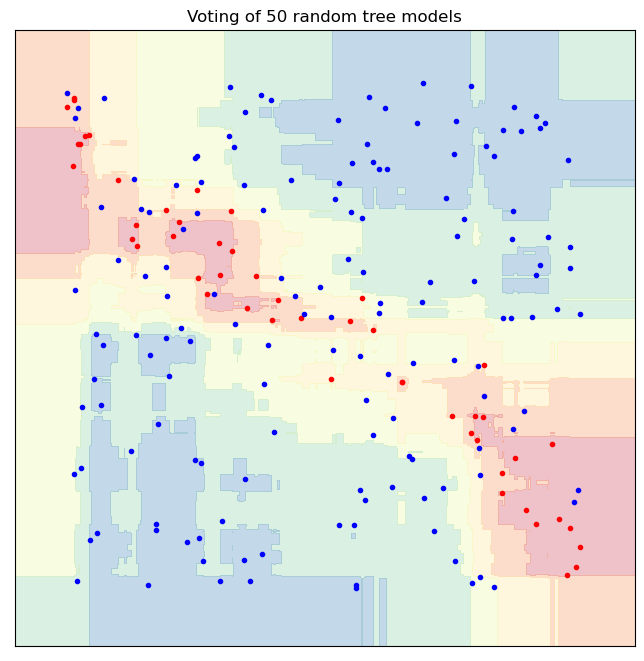

In [9]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=100,
    min_samples_leaf=5,
    class_weight='balanced',
    oob_score= True,
    n_jobs = -1
).fit(data.train.X, data.train.Y)

fig, ax = plt.subplots(1,1, figsize=(8,8))
data.show_model(ax, model)

ax.set_title('Voting of 50 random tree models')

# Ensembles
## 1. Bagging of Classifiers

In [10]:
from sklearn.ensemble import \
    BaggingClassifier, \
    AdaBoostClassifier, \
    GradientBoostingClassifier


def generate_indices(n_population, n_samples):
    """Draw randomly sampled indices."""
    return np.random.randint(0, n_population, n_samples)

def generate_bagging_indices(bootstrap_features, bootstrap_samples):
    """Randomly draw feature and sample indices."""
    # Draw indices
    feature_indices = generate_indices(bootstrap_features, bootstrap_features)
    sample_indices = generate_indices(bootstrap_samples, bootstrap_samples)
    
    mask = np.ones(bootstrap_samples, dtype=bool)
    mask[sample_indices] = False
    out_of_bag, = np.where(mask)
    
    return feature_indices, sample_indices, out_of_bag

for i in range(1, 5):
    print(f'Submodel {i}:')
    f, s, oob = generate_bagging_indices(5, 10)
    print(f'\tIndices of training samples: {s}')
    print(f'\tIndices of test samples: {oob}')
    print(f'\tIndices of features: {f}')
    
# Aggregation == majority voting 
# it can be weighted based on the preformace of oob samples

Submodel 1:
	Indices of training samples: [5 9 3 9 8 1 2 4 3 4]
	Indices of test samples: [0 6 7]
	Indices of features: [2 0 0 1 0]
Submodel 2:
	Indices of training samples: [5 2 1 1 1 7 2 9 0 5]
	Indices of test samples: [3 4 6 8]
	Indices of features: [4 4 4 0 2]
Submodel 3:
	Indices of training samples: [4 6 9 6 3 5 8 2 9 3]
	Indices of test samples: [0 1 7]
	Indices of features: [4 2 2 3 2]
Submodel 4:
	Indices of training samples: [9 2 0 3 3 4 5 0 0 4]
	Indices of test samples: [1 6 7 8]
	Indices of features: [4 3 3 4 3]


## AdaBoost
Adds weight to each sample ($w_i$). Firstly, all the weight are equal.
If weak learner (sub-model) incorrectly classified a sample, it weight is increased.

https://xavierbourretsicotte.github.io/AdaBoost.html

(100, 2)
(100,)


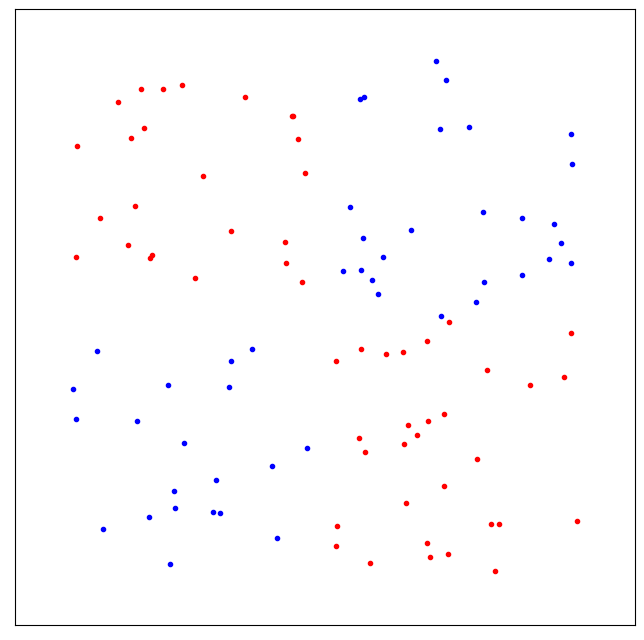

In [11]:
np.random.seed(0)
X = np.random.rand(100, 2)
Y = np.logical_or(
        np.logical_and(X[:,0] < 0.5, X[:,1] < 0.5), 
        np.logical_and(X[:,0] > 0.5, X[:,1] > 0.5), 
        #np.logical_and(X[:,0] > 0.80, X[:,1] > 0.80)
)
print(X.shape)
print(Y.shape)

def show(ax):
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    ax.set_xticks(())
    ax.set_yticks(())

    ax.plot(*X[Y == False].T, '.', color='red')
    ax.plot(*X[Y == True ].T, '.', color='blue')
    
fig, ax = plt.subplots(1,1, figsize=(8,8))
show(ax)

def show_model(ax, model):
    xx, yy = np.meshgrid(np.linspace(-0.1, 1.1, 200), np.linspace(-0.1, 1.1, 200))
    meshpoints =  np.c_[xx.ravel(), yy.ravel()]
    
    Z = model.predict_proba(meshpoints)[:, 1]
    #Z = model.predict(meshpoints)#[:, 1]
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap='Spectral', alpha=.3)
    show(ax)

# Task 1 [1b]
Convert LogisticRegression to be capable of non-binary classification.
Use the One-vs-One multi-class classification.

Help: sklearn.multiclass

In [12]:
import sklearn.multiclass
from sklearn.datasets import make_multilabel_classification
from sklearn.datasets import make_blobs

X, Y = make_blobs(n_samples=1000, centers=3, random_state=1,cluster_std=2, shuffle=True)

plt.plot(*X[Y==0].T, '.', color='blue')
plt.plot(*X[Y==1].T, '.', color='green')
plt.plot(*X[Y==2].T, '.', color='red')

model = ???

DecisionBoundaryDisplay.from_estimator(model, X)
plt.plot(*X[Y==0].T, '.', color='blue')
plt.plot(*X[Y==1].T, '.', color='green')
plt.plot(*X[Y==2].T, '.', color='red')

SyntaxError: invalid syntax (2374646119.py, line 11)

# Taks 2 [1b]
How many classificators are generated when the number of labels is G?

- In the case of One-vs-One multiclass classification
- In the case of One-vs-Rest multiclass classification

???

# Task 3 [1b]
- Use DecisionTree to classify previous probem. 
- Select reasonable hyperparameters.

In [ ]:
model = ???

DecisionBoundaryDisplay.from_estimator(model, X)
plt.plot(*X[Y==0].T, '.', color='blue')
plt.plot(*X[Y==1].T, '.', color='green')
plt.plot(*X[Y==2].T, '.', color='red')

# Task 4 [1b]

Is the output of the formentioned ensemble methods deterministic?

???